
Inspecting training data samples...


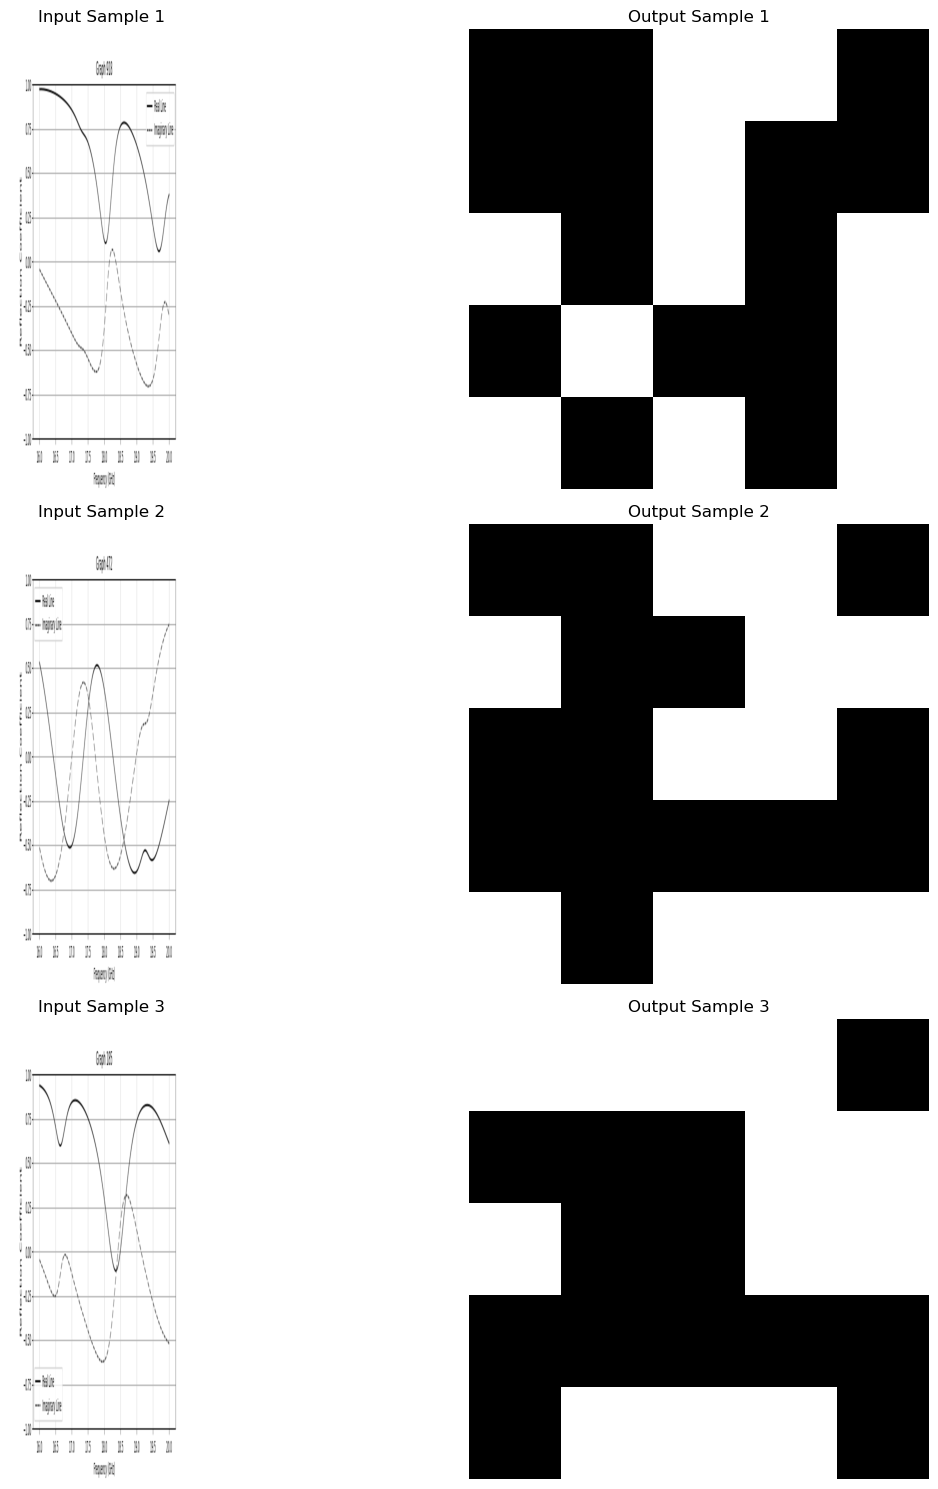

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 742s 6s/step - accuracy: 0.5043 - loss: 1.2754 - val_accuracy: 0.5018 - val_loss: 0.6945 - learning_rate: 1.0000e-05
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 754s 7s/step - accuracy: 0.4989 - loss: 0.6947 - val_accuracy: 0.5017 - val_loss: 0.6938 - learning_rate: 1.0000e-05
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5004 - loss: 0.6938

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from PIL import Image
import matplotlib.pyplot as plt
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
input_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/plots"
output_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/matrix"
input_shape = (1000, 400, 1)  # Grayscale images
output_shape = (50, 50, 1)    # Binary images
batch_size = 8
learning_rate = 1e-5  # Lower learning rate for stability
epochs = 50
threshold = 0.5  # Threshold for binary output

# U-Net-like CNN Model
def build_unet_model(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    c1 = layers.Conv2D(32, 3, padding='same', activation='relu')(c1)
    p1 = layers.MaxPooling2D(2)(c1)
    
    c2 = layers.Conv2D(64, 3, padding='same', activation='relu')(p1)
    c2 = layers.Conv2D(64, 3, padding='same', activation='relu')(c2)
    p2 = layers.MaxPooling2D(2)(c2)
    
    c3 = layers.Conv2D(128, 3, padding='same', activation='relu')(p2)
    c3 = layers.Conv2D(128, 3, padding='same', activation='relu')(c3)
    
    # Decoder
    u2 = layers.UpSampling2D(2)(c3)
    u2 = layers.Concatenate()([u2, c2])
    c4 = layers.Conv2D(64, 3, padding='same', activation='relu')(u2)
    c4 = layers.Conv2D(64, 3, padding='same', activation='relu')(c4)
    
    u1 = layers.UpSampling2D(2)(c4)
    u1 = layers.Concatenate()([u1, c1])
    c5 = layers.Conv2D(32, 3, padding='same', activation='relu')(u1)
    c5 = layers.Conv2D(32, 3, padding='same', activation='relu')(c5)
    
    # Resize to output shape
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(c5)
    x = layers.Conv2D(output_shape[-1], 3, padding='same', activation=None)(x)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    outputs = x
    
    return models.Model(inputs=inputs, outputs=outputs)

# Updated Data Generator with Binary Output Preprocessing
class ImageDataGenerator(Sequence):
    def __init__(self, input_dir, output_dir, batch_size, input_shape, output_shape, pairs=None, **kwargs):
        super().__init__(**kwargs)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        # If pairs are provided, use them; otherwise, generate pairs
        if pairs is None:
            self.pairs = []
            for filename in os.listdir(input_dir):
                if filename.startswith("graph_") and filename.endswith(".png"):
                    x = filename[6:-4]
                    output_path = os.path.join(output_dir, f"{x}.png")
                    if os.path.exists(output_path):
                        self.pairs.append((os.path.join(input_dir, filename), output_path))
                    else:
                        print(f"Warning: Missing output file for {filename}")
            if not self.pairs:
                raise ValueError("No valid input-output pairs found.")
        else:
            self.pairs = pairs
        
        # Shuffle pairs
        np.random.shuffle(self.pairs)
    
    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        batch_input = np.zeros((len(batch_pairs), *self.input_shape))
        batch_output = np.zeros((len(batch_pairs), *self.output_shape))
        
        for i, (input_path, output_path) in enumerate(batch_pairs):
            try:
                # Load and preprocess input image
                input_img = Image.open(input_path).convert('L')
                input_img = input_img.resize((self.input_shape[1], self.input_shape[0]))
                input_img = np.array(input_img) / 255.0
                input_img = np.expand_dims(input_img, axis=-1)
                batch_input[i] = input_img
                
                # Load and preprocess output image (ensure binary)
                output_img = Image.open(output_path).convert('L')
                output_img = output_img.resize((self.output_shape[1], self.output_shape[0]))
                output_img = np.array(output_img)
                # Binarize output (threshold at 128 for 8-bit grayscale)
                output_img = (output_img > 128).astype(np.float32)
                output_img = np.expand_dims(output_img, axis=-1)
                batch_output[i] = output_img
            except Exception as e:
                print(f"Error processing pair {input_path}, {output_path}: {str(e)}")
                continue
        
        return batch_input, batch_output

# Inspect data samples
def inspect_data(generator, num_samples=3):
    inputs, outputs = generator[0]
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(inputs))):
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(inputs[i].squeeze(), cmap='gray')
        plt.title(f'Input Sample {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Output Sample {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Split data into training and validation
all_pairs = []
for filename in os.listdir(input_dir):
    if filename.startswith("graph_") and filename.endswith(".png"):
        x = filename[6:-4]
        output_path = os.path.join(output_dir, f"{x}.png")
        if os.path.exists(output_path):
            all_pairs.append((os.path.join(input_dir, filename), output_path))
        else:
            print(f"Warning: Missing output file for {filename}")

if not all_pairs:
    raise ValueError("No valid input-output pairs found.")

np.random.shuffle(all_pairs)
train_size = int(0.8 * len(all_pairs))
train_pairs = all_pairs[:train_size]
val_pairs = all_pairs[train_size:]

# Create data generators
train_generator = ImageDataGenerator(
    input_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=train_pairs
)
val_generator = ImageDataGenerator(
    input_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=val_pairs
)

# Inspect data before training
print("Inspecting training data samples...")
inspect_data(train_generator, num_samples=3)

# Build and compile the model
model = build_unet_model(input_shape, output_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),  # Gradient clipping
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save("image_translation_model_final.keras")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions with binary thresholding
def visualize_predictions(model, generator, num_samples=3, threshold=0.5):
    inputs, true_outputs = generator[0]
    predictions = model.predict(inputs)
    binary_predictions = (predictions > threshold).astype(np.float32)
    
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(inputs))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(inputs[i].squeeze(), cmap='gray')
        plt.title(f'Input Sample {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Binary Prediction {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    # Verify binary output
    print("Unique values in binary predictions:", np.unique(binary_predictions))

# Evaluate model
def evaluate_model(model, generator, threshold=0.5):
    loss, accuracy = model.evaluate(generator, verbose=0)
    print(f"Binary Cross-Entropy Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    inputs, true_outputs = generator[0]
    preds = model.predict(inputs)
    binary_preds = (preds > threshold).astype(np.float32)
    
    try:
        true_tensor = tf.convert_to_tensor(true_outputs, dtype=tf.float64)
        pred_tensor = tf.convert_to_tensor(binary_preds, dtype=tf.float64)
        ssim = tf.image.ssim(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        print(f"Structural Similarity (SSIM): {ssim:.4f}")
        print(f"Peak SNR (PSNR): {psnr:.2f} dB")
        
        return {'loss': loss, 'accuracy': accuracy, 'ssim': ssim, 'psnr': psnr}
    except Exception as e:
        print(f"Error calculating quality metrics: {str(e)}")
        return {'loss': loss, 'accuracy': accuracy, 'ssim': None, 'psnr': None}

# Run visualization and evaluation
visualize_predictions(model, val_generator, num_samples=3, threshold=threshold)
metrics = evaluate_model(model, val_generator, threshold=threshold)